# **Example statistical analysis on physiological time-series**

The notebook will be structured as follows:

1) Load Your Data: The notebook will start by importing a time series dataset.
2) Segment the Data: This dataset will be segmented into shorter bouts of a specified duration, preparing it for further analysis.
3) Cluster the Data: The segmented data will undergo K-means clustering analysis. This process will classify each time point into distinct clusters, effectively labeling them based on their similarities and differences.
4) Create a Labeled DataFrame: The resulting data, along with the cluster labels, will be organized into a DataFrame. This DataFrame will consist of two columns: 'data_values', which contains the physiological data points, and 'label_id', which holds the corresponding cluster labels assigned to each data point.
5) Statistical Analysis: Utilizing my custom statistics library (referred to as 'mylib'), the notebook will conduct comparative statistical analyses. This step aims to discern significant patterns or differences between the clustered data.
6) Data Visualization: Finally, the results of the statistical analyses will be visualized using interactive box plots, created with the Vega-Lite visualization library. This will provide an intuitive and interactive way to explore and interpret the analyzed data.


# Required librairies

In [60]:
pip install pandas scikit-learn numpy seaborn altair

Note: you may need to restart the kernel to use updated packages.


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import mode




# 1) Load Your Data

I found temperature measurements of a shark here : https://figshare.com/articles/dataset/Data_for_Body_temperature_stability_in_the_whale_shark_the_world_s_largest_fish/12355955


       Timestamp  Temperature            DateTime
10272        0.0        28.38 2016-10-17 11:17:00
10273        1.0        28.38 2016-10-17 11:18:00
10274        2.0        28.38 2016-10-17 11:19:00
10275        3.0        28.38 2016-10-17 11:20:00
10276        4.0        28.38 2016-10-17 11:21:00
...
       Timestamp  Temperature            DateTime
16245     5973.0        27.68 2016-10-21 14:50:00
16246     5974.0        27.68 2016-10-21 14:51:00
16247     5975.0        27.66 2016-10-21 14:52:00
16248     5976.0        27.67 2016-10-21 14:53:00
16249     5977.0        27.70 2016-10-21 14:54:00


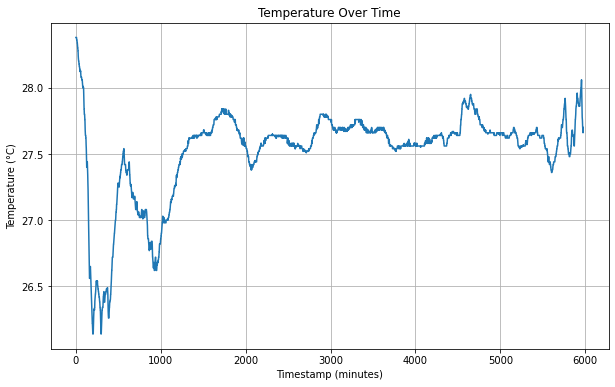

In [62]:
def load_data():

    # URL of the CSV file
    csv_url = 'https://figshare.com/ndownloader/files/22772111'
    
    # Download and read the CSV file into a pandas DataFrame
    data = pd.read_csv(csv_url)

    # Filter the DataFrame for rows where 'Shark ID' matches and select only 'Timestamp' and 'Temperature' columns
    SharkID = 'C2'
    data = data[data['Shark ID'] == SharkID]
    data = data.rename(columns={'MuscleTemp': 'Temperature'})
    
    # Convert 'Date' to datetime
    data['DateTime'] = pd.to_datetime(data['Date'])
    
    # Normalize timestamps starting at 0
    data['Timestamp'] = (data['DateTime'] - data['DateTime'].iloc[0]).dt.total_seconds() / 60

    # Filter the DataFrame for rows where 'sharkID' matches and select only 'Timestamp' and 'Temperature' columns
    data = data[['Timestamp', 'Temperature','DateTime']]

    # Remove nans from data if present
    data = data.dropna(subset=['Temperature'])
    data = data.dropna(subset=['Timestamp'])
    
    # Check if the time intervals are uniform
    time_diffs = data['Timestamp'].diff().dropna().unique()

    MISSING_VALUES = len(time_diffs) > 1
    
    # Interpolate missing values
    if MISSING_VALUES:
        # Resample the data to the smallest common interval
        smallest_interval = pd.to_timedelta(time_diffs.min())
        print(smallest_interval)
        data.set_index('DateTime', inplace=True)
        data = data.resample(smallest_interval).mean()
        data.reset_index(inplace=True)
    
        # Interpolate the missing values in 'Temperature'
        data['Temperature'] = data['Temperature'].interpolate()
        data['Timestamp'] = data['Timestamp'].interpolate()

    
    # Display the first few rows of the new_df
    print(data.head())
    print('...')
    print(data.tail())
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(data['Timestamp'], data['Temperature'])
    plt.title('Temperature Over Time')
    plt.xlabel('Timestamp (minutes)')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.show()
    
    return data

data = load_data()


# 2) Segment the Data

In [63]:
def segment_data_by_time_interval(data, interval_in_minutes):
    """
    Segments the data into windows based on a time interval in minutes.
    
    :param data: Pandas DataFrame with 'Timestamp' and 'Temperature' columns.
    :param interval_in_minutes: Size of the time interval to segment the data into.
    :return: A list of numpy arrays, where each array is a segment of the 'Temperature' column.
    """
    # Ensure 'Timestamp' is a datetime series
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    
    # Calculate the differences between consecutive timestamps
    time_diffs = data['DateTime'].diff().dropna().dt.total_seconds() / 60  # Convert to minutes
    common_diff = time_diffs.mode()[0]  # Find the most common time difference
    
    
    # Calculate the number of data points per segment
    points_per_segment = int(interval_in_minutes / common_diff)
    
    # Segment the data
    num_segments = len(data) // points_per_segment
    segments = [data.iloc[i * points_per_segment:(i + 1) * points_per_segment]['Temperature'].values 
                for i in range(num_segments)]

    # Normalisation: for each segment subtract first value# Segment the data and normalize each segment
    segments = [segment-segment[0] for segment in segments ]
    
    return segments,points_per_segment

# Example usage
segment_size_in_minutes = 10  # Change this to the desired interval in minutes

# Assuming 'data' is a DataFrame that includes 'Timestamp' and 'Temperature' columns
segments,points_per_segment = segment_data_by_time_interval(data, segment_size_in_minutes)

# Print the first segment to verify, if any segments were created
print(f'First segment: {segments[0]}')
print(f'Last segment: {segments[-1]}')
print(f'Points per segment: {points_per_segment}')


First segment: [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.02 -0.02]
Last segment: [ 0.   -0.01 -0.03 -0.06 -0.11 -0.13 -0.15 -0.15 -0.16 -0.19]
Points per segment: 10


# 3) Cluster the Data

In [64]:

def k_means_clustering_on_segments(segments, n_clusters):
    """
    Applies K-Means clustering to windowed segments of time series data.
    :param segments: List of data segments.
    :param n_clusters: The number of clusters to form.
    :return: A list of cluster labels for each segment.
    """
    
    # Convert list of segments to a 2D numpy array
    segment_array = np.array(segments)
    
    # Check if we have enough segments to cluster
    if len(segment_array) == 0:
        raise ValueError("Not enough data to form a single segment. Increase data size or decrease window size.")
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    kmeans.fit(segment_array)
    
    # Get cluster labels for each segment
    cluster_labels = kmeans.labels_
    
    return cluster_labels

# Example usage
# Assuming 'data' is your DataFrame with a 'Temperature' column
n_clusters = 10   # The desired number of clusters

# Perform clustering
cluster_labels = k_means_clustering_on_segments(segments, n_clusters)


# 4) Create a Labeled DataFrame

In [65]:
def label_data_with_clusters(data, cluster_labels, points_per_segment):
    """
    Labels the original data with the cluster labels obtained from K-Means clustering on segments.
    
    :param data: Pandas DataFrame with 'Temperature' column.
    :param cluster_labels: The cluster labels for each segment.
    :param points_per_segment: The size of the window used to segment the data.
    :return: Pandas DataFrame with an additional 'cluster_label' column.
    """
    # Create an empty list to hold the cluster labels for each data point
    all_labels = [[] for _ in range(len(data))]
    
    # Assign each segment's cluster label to its constituent data points
    for iseg, label in enumerate(cluster_labels):
        for ipoint in range(points_per_segment):
            idx = iseg * points_per_segment + ipoint
            # Make sure we don't go out of bounds at the end
            if idx < len(data):
                all_labels[idx].append(label)

    # Determine the most common label for data points that belong to multiple segments
    final_labels = [max(set(labels), key=labels.count) if labels else None for labels in all_labels]
    
    # Add the cluster labels to the DataFrame
    data['cluster_label'] = final_labels
    return data

# Example usage
# Make sure the data, cluster_labels, and points_per_segment are already defined
data_labeled = label_data_with_clusters(data, cluster_labels, points_per_segment)


# 5) Statistical Analysis

## Import mystats module

In [76]:
!pip uninstall mylib -y
!pip install git+https://github.com/karinmcode/mylib.git
import mylib.stats as mystats


Found existing installation: mylib 231206
Uninstalling mylib-231206:
  Successfully uninstalled mylib-231206
  Cloning https://github.com/karinmcode/mylib.git to /private/var/folders/9m/98gclsr129g89m_8s8t86s080000gn/T/pip-req-build-3pxnus9f
  Running command git clone --filter=blob:none --quiet https://github.com/karinmcode/mylib.git /private/var/folders/9m/98gclsr129g89m_8s8t86s080000gn/T/pip-req-build-3pxnus9f
  Resolved https://github.com/karinmcode/mylib.git to commit 6b201aba36b689535204f2b39eb079820dd6db13
  Preparing metadata (setup.py) ... done
  Created wheel for mylib: filename=mylib-231206-py3-none-any.whl size=29964 sha256=66cb46c59631490ad8c189732ae95fd3e2e9bf1b66661703bcc834ab8ff31c61
  Stored in directory: /private/var/folders/9m/98gclsr129g89m_8s8t86s080000gn/T/pip-ephem-wheel-cache-wtpzzzzx/wheels/8d/0a/a8/86dc6fd0954eb4fd33ca4c8581f9b45a2375305c8c9d20d4ee
Successfully built mylib


In [77]:
# Assuming 'NaN_Group' is the value or the integer you've assigned to the NaN groups
data_labeled = data_labeled[data_labeled['cluster_label'] != 'NaN_Group']

test_used, p_value ,significant_combinations = mystats.perform_comparative_statistics(data_labeled, 'cluster_label', 'Temperature',alpha=0.05,verbose=True)


        grp -1 grp 0   grp 1   grp 2   grp 3  ... grp 5 grp 6 grp 7 grp 8 grp 9
grp -1                                        ...                              
grp 0       ns                                ...                              
grp 1      0.0   0.0                          ...                              
grp 2   0.0015   0.0      ns                  ...                              
grp 3   0.0112   0.0  0.0002      ns          ...                              
grp 4   0.0206   0.0      ns      ns      ns  ...                              
grp 5       ns   0.0     0.0     0.0     0.0  ...                              
grp 6   0.0001   0.0      ns      ns  0.0004  ...   0.0                        
grp 7       ns    ns     0.0     0.0     0.0  ...    ns   0.0                  
grp 8       ns    ns     0.0     0.0     0.0  ...   0.0   0.0    ns            
grp 9      0.0   0.0      ns  0.0305  0.0017  ...   0.0    ns   0.0   0.0      

[11 rows x 11 columns]

Statistical Tes

# 6) Data Visualization

## Time series with clusters

### matplotlib Version

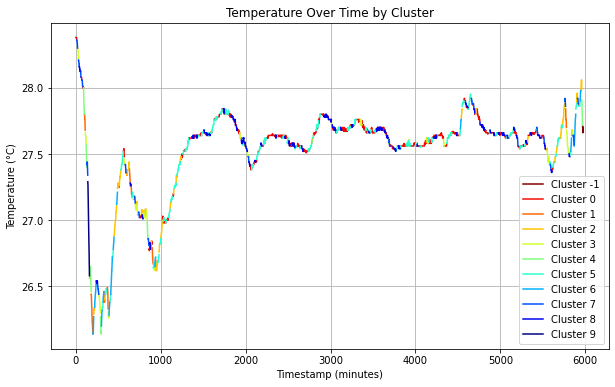

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data setup (replace this with your actual data)
data = data_labeled

# Assuming 'data' is your DataFrame and 'Timestamp' is a datetime column
data['Timestamp'] = (data['DateTime'] - data['DateTime'].min()).dt.total_seconds() / 60

# Set up the plot
plt.figure(figsize=(10, 6))

# Unique cluster labels
unique_clusters = np.sort(data['cluster_label'].unique())

# Color map (you can choose a different color map or specify colors manually)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_clusters)))

# Reverse the colors array
colors = colors[::-1]

# Plot each segment with a different color
for cluster, color in zip(unique_clusters, colors):
    # Create a copy of the data to avoid modifying the original dataframe
    data_clu = data.copy()
    
    # Introduce NaNs where the cluster label does not match the current cluster
    data_clu.loc[data_clu['cluster_label'] != cluster, 'Temperature'] = np.nan
    
    plt.plot(data_clu['Timestamp'], data_clu['Temperature'], label=f'Cluster {cluster}', color=color)

# Adding labels and title
plt.title('Temperature Over Time by Cluster')
plt.xlabel('Timestamp (minutes)')
plt.ylabel('Temperature (°C)')
plt.grid(True)

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()


### VegaLite Version

In [95]:
!pip install altair vega_datasets
import altair as alt
import json


In [124]:
import matplotlib.colors

dataV = data[1400::]

alt.data_transformers.enable('data_server')


# Calculate the min and max for the Temperature data
min_temp = dataV['Temperature'].min()
max_temp = dataV['Temperature'].max()

# Calculate the min and max for the Timestamp data
min_time = dataV['Timestamp'].min()
max_time = dataV['Timestamp'].max()

# Make sure that Altair is configured to work in a Jupyter environment
alt.renderers.enable('default')

# Assuming 'data' is your DataFrame and you've already processed 'Timestamp'
# Unique cluster labels
unique_clusters = np.sort(dataV['cluster_label'].unique())

# Color map
colors = plt.cm.jet(np.linspace(0, 1, len(unique_clusters)))

# Create a list to hold all the layers
layers = []

# Iterate over the clusters to create individual layers
for cluster, color in zip(unique_clusters, colors):
    
    # Create a copy of the data to avoid modifying the original dataframe
    cluster_data = dataV.copy()
    
    # Introduce NaNs where the cluster label does not match the current cluster
    cluster_data.loc[cluster_data['cluster_label'] != cluster, 'Temperature'] = np.nan
    #cluster_data = cluster_data[cluster_data['cluster_label']==cluster]

    # Convert the cluster data to JSON
    data_json = cluster_data.to_json(orient='records')

    
    # Parse the JSON string into a Python object
    alt_data = alt.Data(values=data_json)
    
    # Create a line mark for the current cluster
    line = alt.Chart(alt_data).mark_line(
        color=matplotlib.colors.rgb2hex(color)  # Convert matplotlib color to hex format
    ).encode(
        x=alt.X('Timestamp:Q', title='Timestamp (minutes)', scale=alt.Scale(domain=(min_time, max_time))),
        y=alt.Y('Temperature:Q', title='Temperature (°C)', scale=alt.Scale(domain=(min_temp, max_temp))),
        tooltip=[
            alt.Tooltip('Timestamp:Q'),
            alt.Tooltip('Temperature:Q'),
            alt.Tooltip('cluster_label:N')
        ]
    )
    
    # Add the line mark to the layers
    layers.append(line)



## Add vertical hover
# For the interactive hover effect, we will create a selection that chooses the nearest point & selects on mouseover
nearest = alt.selection(type='single', nearest=True, on='mouseover', fields=['Timestamp'], empty='none')

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(data).mark_point().encode(
    x='Timestamp:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)
layers.append(selectors)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)
layers.append(points)

# Draw a rule at the location of the selection
rules = alt.Chart(data).mark_rule(color='gray').encode(
    x='Timestamp:Q',
).transform_filter(
    nearest
)
layers.append(rules)


# Layer all the lines on the same chart
chart = alt.layer(*layers).interactive().properties(
    width=700, height=400
)

# Display the chart
chart


alt.LayerChart(...)

## Overview of clusters using dimensionality reduction

## Statistical analysis between clusters (boxplots)